In [1]:
import os
import subprocess
import matplotlib.pyplot as plt
import matplotlib as mpl
from upsetplot import UpSet, from_contents
import pyfastx

from varseek.utils import get_set_of_headers_from_sam, parse_sam_and_extract_sequences

11:28:28 - INFO - Old pandas version detected. Patching DataFrame.map to DataFrame.applymap


In [2]:
k = 31
bowtie_reference_folder_parent = f"/home/jrich/Desktop/gget_mutate_project_clean_k{k}_transcriptome/data/TEMP_bowtie_tests"
mutation_reference_file_fasta = f"/home/jrich/Desktop/gget_mutate_project_clean_k{k}_transcriptome/data/mutant_reference/cancer_mutant_reference_transcriptome_cdna.fa"  # before any filtering
threads = 32

ensembl_version_dlist_grch37 = 93
ensembl_version_dlist_grch38 = 112
dfk_length = k - 1

In [14]:
def run_bowtie_build(bowtie2_build, threads, reference_fasta, bowtie_reference_folder, dry_run = False):
    bowtie_genome_build_command = f"{bowtie2_build} --threads {threads} {reference_fasta} {bowtie_reference_folder}"
    if dry_run:
        print(bowtie_genome_build_command, "&& \\")
        return
    result = subprocess.run(bowtie_genome_build_command, shell=True, check=True)
    return result

def run_bowtie_align(bowtie2, threads, k, bowtie_reference_folder, mutation_reference_file_fasta, output_sam_file, dry_run):
    bowtie_genome_align_command = f"{bowtie2} -a -f -p {threads} --xeq --score-min C,0,0 --np 1 --n-ceil C,0,0 -F {k},1 -R 1 -N 0 -L 31 -i C,1,0 --no-1mm-upfront --no-unal -x {bowtie_reference_folder} -U {mutation_reference_file_fasta} -S {output_sam_file}"
    if dry_run:
        print(bowtie_genome_align_command, "&& \\")
        return
    result = subprocess.run(bowtie_genome_align_command, shell=True, check=True)
    return result

def create_header_and_sequence_set(dlist_fasta_file):
    header_and_sequence_set = set()
    for header, sequence in pyfastx.Fastx(dlist_fasta_file):
        header_and_sequence_entry = header + "_" + sequence
        header_and_sequence_set.add(header_and_sequence_entry)
    return header_and_sequence_set

def save_set(set_name, file_path):
    with open(file_path, "w") as file:
        for item in set_name:
            file.write(f"{item}\n")

def read_set(file_path):
    with open(file_path, "r") as file:
        return {line.strip() for line in file}

def run_full_alignment_workflow(bowtie_reference_folder_parent, mutation_reference_file_fasta, reference_source, dfk_length = None, threads = 32, k = 31, release = None, dry_run = False):
    bowtie2_build = "bowtie2-build"
    bowtie2 = "bowtie2"
    
    bowtie_genome_reference_folder = f"{bowtie_reference_folder_parent}/{reference_source}_genome_bowtie_reference/index"
    bowtie_cdna_reference_folder = f"{bowtie_reference_folder_parent}/{reference_source}_transcriptome_bowtie_reference/index"
    os.makedirs(os.path.dirname(bowtie_genome_reference_folder), exist_ok=True)
    os.makedirs(os.path.dirname(bowtie_cdna_reference_folder), exist_ok=True)
    genome_sam_file = f"{bowtie_reference_folder_parent}/mutant_reads_to_{reference_source}_index_genome/output.sam"
    cdna_sam_file = f"{bowtie_reference_folder_parent}/mutant_reads_to_{reference_source}_index_cdna/output.sam"
    os.makedirs(os.path.dirname(genome_sam_file), exist_ok=True)
    os.makedirs(os.path.dirname(cdna_sam_file), exist_ok=True)

    dlist_fasta_file_genome = f"{bowtie_reference_folder_parent}/mutant_reads_to_{reference_source}_index_genome/dlist.fasta"
    dlist_fasta_file_cdna = f"{bowtie_reference_folder_parent}/mutant_reads_to_{reference_source}_index_cdna/dlist.fasta"
    os.makedirs(os.path.dirname(dlist_fasta_file_genome), exist_ok=True)
    os.makedirs(os.path.dirname(dlist_fasta_file_cdna), exist_ok=True)

    if reference_source == "grch37":
        if release > 87:
            ensembl_version_dlist_gtf = 87
        else:
            ensembl_version_dlist_gtf = release
        human_reference_for_dlist_folder = f'{bowtie_reference_folder_parent}/reference/GRCh_Ensembl/GRCh37_Ensembl{release}'
        os.makedirs(human_reference_for_dlist_folder, exist_ok = True)
        genome_fasta = f"{human_reference_for_dlist_folder}/Homo_sapiens.GRCh37.dna.primary_assembly.fa"
        cdna_fasta = f"{human_reference_for_dlist_folder}/Homo_sapiens.GRCh37.cdna.all.fa"
        gtf_file = f"{human_reference_for_dlist_folder}/Homo_sapiens.GRCh37.{ensembl_version_dlist_gtf}.gtf"
        gget_ref_command = f"gget ref -w dna,cdna,gtf -r {release} --out_dir {human_reference_for_dlist_folder} -d human_grch37 && gunzip {genome_fasta}.gz && gunzip {cdna_fasta}.gz && gunzip {gtf_file}.gz"
        if dry_run:
            print(gget_ref_command, "&& \\")
        else:
            if not os.path.exists(genome_fasta):
                result = subprocess.run(gget_ref_command, shell=True, check=True)

    elif reference_source == "grch38":
        human_reference_for_dlist_folder = f'{bowtie_reference_folder_parent}/reference/GRCh_Ensembl/GRCh38_Ensembl{ensembl_version_dlist_grch38}'
        os.makedirs(human_reference_for_dlist_folder, exist_ok = True)
        genome_fasta = f"{human_reference_for_dlist_folder}/Homo_sapiens.GRCh38.dna.primary_assembly.fa"
        cdna_fasta = f"{human_reference_for_dlist_folder}/Homo_sapiens.GRCh38.cdna.all.fa"
        gtf_file = f"{human_reference_for_dlist_folder}/Homo_sapiens.GRCh38.{release}.gtf"
        gget_ref_command = f"gget ref -w dna,cdna,gtf -r {release} --out_dir {human_reference_for_dlist_folder} -d human && gunzip {genome_fasta}.gz && gunzip {cdna_fasta}.gz && gunzip {gtf_file}.gz"
        if dry_run:
            print(gget_ref_command, "&& \\")
        else:
            if not os.path.exists(genome_fasta):
                result = subprocess.run(gget_ref_command, shell=True, check=True)
    
    elif reference_source == "t2t":
        human_reference_for_dlist_folder = f'{bowtie_reference_folder_parent}/reference/T2T/GCF_009914755.1'
        os.makedirs(human_reference_for_dlist_folder, exist_ok = True)
        genome_fasta = f"{human_reference_for_dlist_folder}/GCF_009914755.1_T2T-CHM13v2.0_genomic.fna"
        cdna_fasta = f"{human_reference_for_dlist_folder}/rna.fna"
        gtf_file = f"{human_reference_for_dlist_folder}/genomic.gtf"
        gget_ref_command = f'wget -O {human_reference_for_dlist_folder}/t2t.zip "https://api.ncbi.nlm.nih.gov/datasets/v2alpha/genome/accession/GCF_009914755.1/download?include_annotation_type=GENOME_FASTA&include_annotation_type=RNA_FASTA&include_annotation_type=GENOME_GTF&hydrated=FULLY_HYDRATED" && unzip {human_reference_for_dlist_folder}/t2t.zip -d {human_reference_for_dlist_folder}/temp && mv {human_reference_for_dlist_folder}/temp/ncbi_dataset/data/GCF_009914755.1/* {human_reference_for_dlist_folder} && rm -rf {human_reference_for_dlist_folder}/temp'
        if dry_run:
            print(gget_ref_command, "&& \\")
        else:
            if not os.path.exists(genome_fasta):
                result = subprocess.run(gget_ref_command, shell=True, check=True)
    
    else:
        raise ValueError("Release must be either grch37, grch38, or t2t")

    if not os.path.exists(f"{bowtie_genome_reference_folder}.1.bt2"):
        result = run_bowtie_build(bowtie2_build = bowtie2_build, threads = threads, reference_fasta = genome_fasta, bowtie_reference_folder = bowtie_genome_reference_folder, dry_run = dry_run)

    if not os.path.exists(genome_sam_file):
        result = run_bowtie_align(bowtie2 = bowtie2, threads = threads, k = k, bowtie_reference_folder = bowtie_genome_reference_folder, mutation_reference_file_fasta = mutation_reference_file_fasta, output_sam_file = genome_sam_file, dry_run = dry_run)
    
    if not os.path.exists(dlist_fasta_file_genome) and not dry_run:
        parse_sam_and_extract_sequences(genome_sam_file, genome_fasta, dlist_fasta_file_genome, k = k, dfk_length = dfk_length, capitalize = True, remove_duplicates = False)

    if not os.path.exists(f"{bowtie_cdna_reference_folder}.1.bt2"):
        result = run_bowtie_build(bowtie2_build = bowtie2_build, threads = threads, reference_fasta = cdna_fasta, bowtie_reference_folder = bowtie_cdna_reference_folder, dry_run = dry_run)

    if not os.path.exists(cdna_sam_file):
        result = run_bowtie_align(bowtie2 = bowtie2, threads = threads, k = k, bowtie_reference_folder = bowtie_cdna_reference_folder, mutation_reference_file_fasta = mutation_reference_file_fasta, output_sam_file = cdna_sam_file, dry_run = dry_run)

    if not os.path.exists(dlist_fasta_file_cdna) and not dry_run:
        parse_sam_and_extract_sequences(cdna_sam_file, cdna_fasta, dlist_fasta_file_cdna, k = k, dfk_length = dfk_length, capitalize = True, remove_duplicates = False)
        
    if dry_run:
        return "", "", "", ""
    
    sequence_names_set_genome = get_set_of_headers_from_sam(genome_sam_file, k = k)
    sequence_names_set_cdna = get_set_of_headers_from_sam(cdna_sam_file, k = k)

    header_and_sequence_set_genome = create_header_and_sequence_set(dlist_fasta_file_genome)
    header_and_sequence_set_cdna = create_header_and_sequence_set(dlist_fasta_file_cdna)

    set_parent = f"{bowtie_reference_folder_parent}/sets"
    os.makedirs(set_parent, exist_ok = True)
    save_set(sequence_names_set_genome, f"{set_parent}/{reference_source}_sequence_names_set_genome.txt")
    save_set(sequence_names_set_cdna, f"{set_parent}/{reference_source}_sequence_names_set_cdna.txt")
    save_set(header_and_sequence_set_genome, f"{set_parent}/{reference_source}_header_and_sequence_set_genome.txt")
    save_set(header_and_sequence_set_cdna, f"{set_parent}/{reference_source}_header_and_sequence_set_cdna.txt")

    return sequence_names_set_genome, sequence_names_set_cdna, header_and_sequence_set_genome, header_and_sequence_set_cdna




def show_upset_within_references(sequence_names_set_genome, sequence_names_set_cdna, title = ""):
    upset_data_dict = from_contents(
        {"genome": sequence_names_set_genome, "cdna": sequence_names_set_cdna}
    )

    upset_plot = UpSet(upset_data_dict, subset_size="count", show_counts=True, show_percentages=True)

    mpl.rcParams['font.size'] = 7

    upset_plot.plot()
    plt.suptitle(title)
    
    sequence_names_set_genome_combined = sequence_names_set_genome | sequence_names_set_cdna
    plt.text(0, 0.5, f"Union: {len(sequence_names_set_genome_combined)}", fontsize=7, transform=plt.gcf().transFigure)

    

    plt.show()

    return upset_plot

def show_upset_between_references(sequence_names_set_genome_t2t, sequence_names_set_genome_grch38, sequence_names_set_genome_grch37, data_type, title = None):
    upset_data_dict = from_contents(
        {f"T2T_{data_type}": sequence_names_set_genome_t2t, f"GRCh38_{data_type}": sequence_names_set_genome_grch38, f"GRCh37_{data_type}": sequence_names_set_genome_grch37}
    )

    upset_plot = UpSet(upset_data_dict, subset_size="count", show_counts=True, show_percentages=True)

    mpl.rcParams['font.size'] = 7

    if title is None:
        title = f"T2T vs GRCh38 vs GRCh37: {data_type}"

    upset_plot.plot()
    plt.suptitle(title)
    plt.show()

    return upset_plot

In [15]:
sequence_names_set_genome_t2t, sequence_names_set_cdna_t2t, header_and_sequence_set_genome_t2t, header_and_sequence_set_cdna_t2t = run_full_alignment_workflow(bowtie_reference_folder_parent = bowtie_reference_folder_parent, mutation_reference_file_fasta = mutation_reference_file_fasta, reference_source = "t2t", release = None, dfk_length = dfk_length, threads = threads, k = k)
sequence_names_set_genome_grch38, sequence_names_set_cdna_grch38, header_and_sequence_set_genome_grch38, header_and_sequence_set_cdna_grch38 = run_full_alignment_workflow(bowtie_reference_folder_parent = bowtie_reference_folder_parent, mutation_reference_file_fasta = mutation_reference_file_fasta, reference_source = "grch38", release = ensembl_version_dlist_grch38, dfk_length = dfk_length, threads = threads, k = k)
sequence_names_set_genome_grch37, sequence_names_set_cdna_grch37, header_and_sequence_set_genome_grch37, header_and_sequence_set_cdna_grch37 = run_full_alignment_workflow(bowtie_reference_folder_parent = bowtie_reference_folder_parent, mutation_reference_file_fasta = mutation_reference_file_fasta, reference_source = "grch37", release = ensembl_version_dlist_grch37, dfk_length = dfk_length, threads = threads, k = k)

Skipped 0 reads with bad CIGAR strings
Capitalizing sequences
Skipped 0 reads with bad CIGAR strings
Capitalizing sequences
Skipped 0 reads with bad CIGAR strings
Capitalizing sequences


In [5]:
# header_and_sequence_set_cdna_grch37 = read_set("/home/jrich/Desktop/gget_mutate_project_clean_k31_transcriptome/data/TEMP_bowtie_tests/sets/grch37_header_and_sequence_set_cdna.txt")
# header_and_sequence_set_cdna_grch38 = read_set("/home/jrich/Desktop/gget_mutate_project_clean_k31_transcriptome/data/TEMP_bowtie_tests/sets/grch38_header_and_sequence_set_cdna.txt")
# header_and_sequence_set_cdna_t2t = read_set("/home/jrich/Desktop/gget_mutate_project_clean_k31_transcriptome/data/TEMP_bowtie_tests/sets/t2t_header_and_sequence_set_cdna.txt")
# header_and_sequence_set_genome_grch37 = read_set("/home/jrich/Desktop/gget_mutate_project_clean_k31_transcriptome/data/TEMP_bowtie_tests/sets/grch37_header_and_sequence_set_genome.txt")
# header_and_sequence_set_genome_grch38 = read_set("/home/jrich/Desktop/gget_mutate_project_clean_k31_transcriptome/data/TEMP_bowtie_tests/sets/grch38_header_and_sequence_set_genome.txt")
# header_and_sequence_set_genome_t2t = read_set("/home/jrich/Desktop/gget_mutate_project_clean_k31_transcriptome/data/TEMP_bowtie_tests/sets/t2t_header_and_sequence_set_genome.txt")

# sequence_names_set_cdna_grch37 = read_set("/home/jrich/Desktop/gget_mutate_project_clean_k31_transcriptome/data/TEMP_bowtie_tests/sets/grch37_sequence_names_set_cdna.txt")
# sequence_names_set_cdna_grch38 = read_set("/home/jrich/Desktop/gget_mutate_project_clean_k31_transcriptome/data/TEMP_bowtie_tests/sets/grch38_sequence_names_set_cdna.txt")
# sequence_names_set_cdna_t2t = read_set("/home/jrich/Desktop/gget_mutate_project_clean_k31_transcriptome/data/TEMP_bowtie_tests/sets/t2t_sequence_names_set_cdna.txt")
# sequence_names_set_genome_grch37 = read_set("/home/jrich/Desktop/gget_mutate_project_clean_k31_transcriptome/data/TEMP_bowtie_tests/sets/grch37_sequence_names_set_genome.txt")
# sequence_names_set_genome_grch38 = read_set("/home/jrich/Desktop/gget_mutate_project_clean_k31_transcriptome/data/TEMP_bowtie_tests/sets/grch38_sequence_names_set_genome.txt")
# sequence_names_set_genome_t2t = read_set("/home/jrich/Desktop/gget_mutate_project_clean_k31_transcriptome/data/TEMP_bowtie_tests/sets/t2t_sequence_names_set_genome.txt")

In [16]:
sequence_names_set_t2t = sequence_names_set_genome_t2t | sequence_names_set_cdna_t2t
sequence_names_set_grch38 = sequence_names_set_genome_grch38 | sequence_names_set_cdna_grch38
sequence_names_set_grch37 = sequence_names_set_genome_grch37 | sequence_names_set_cdna_grch37

header_and_sequence_set_t2t = header_and_sequence_set_genome_t2t | header_and_sequence_set_cdna_t2t
header_and_sequence_set_grch38 = header_and_sequence_set_genome_grch38 | header_and_sequence_set_cdna_grch38
header_and_sequence_set_grch37 = header_and_sequence_set_genome_grch37 | header_and_sequence_set_cdna_grch37

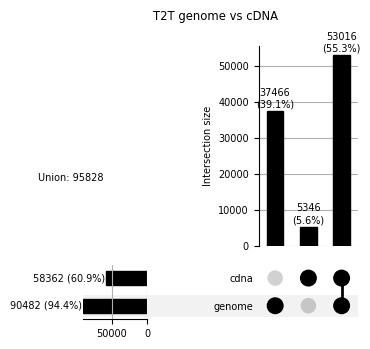

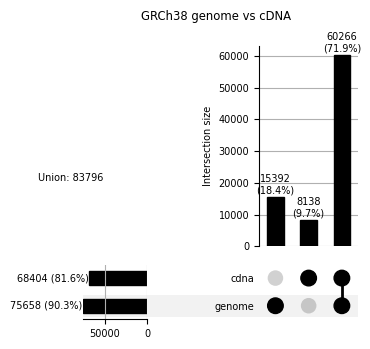

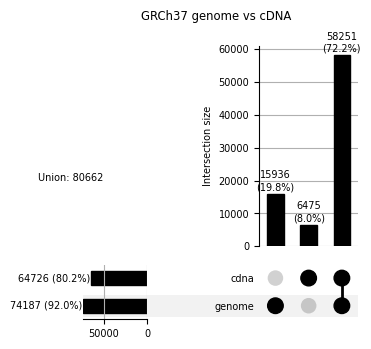

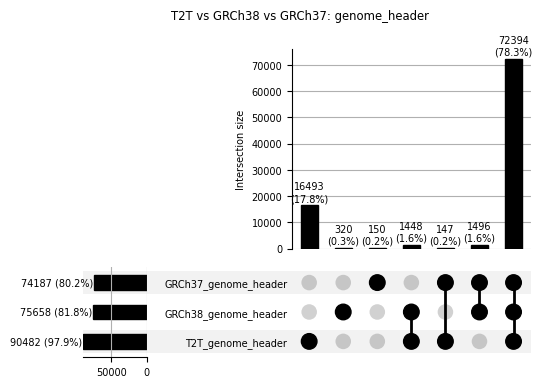

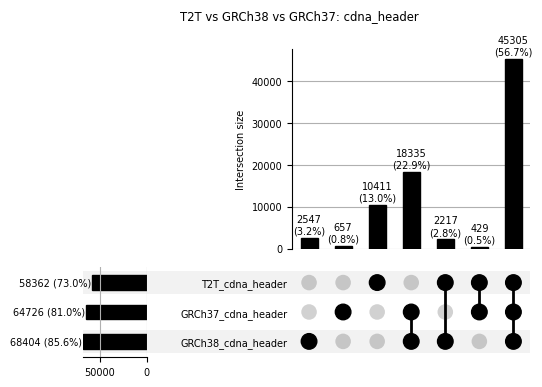

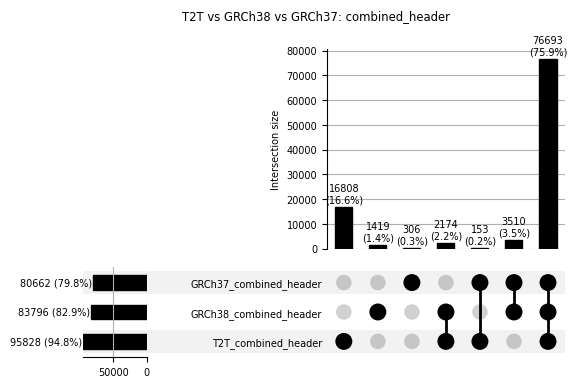

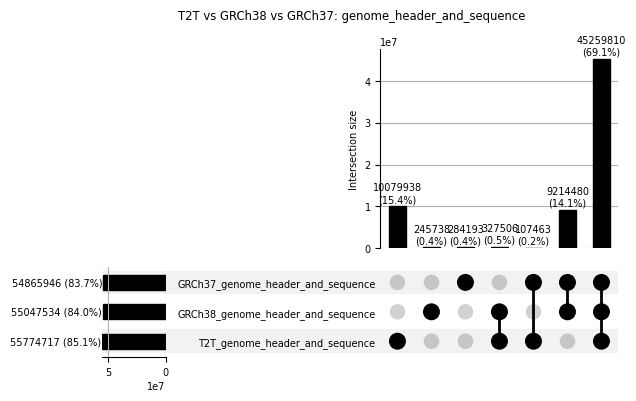

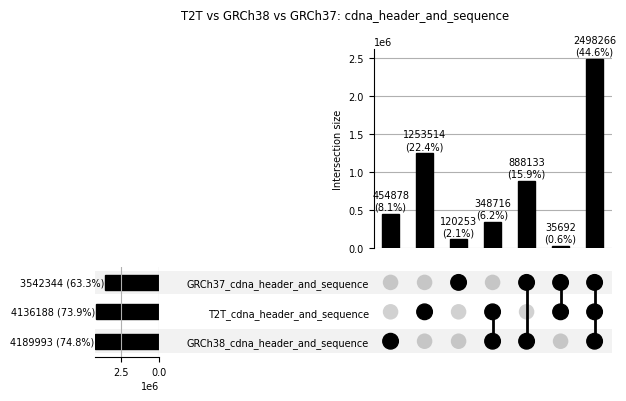

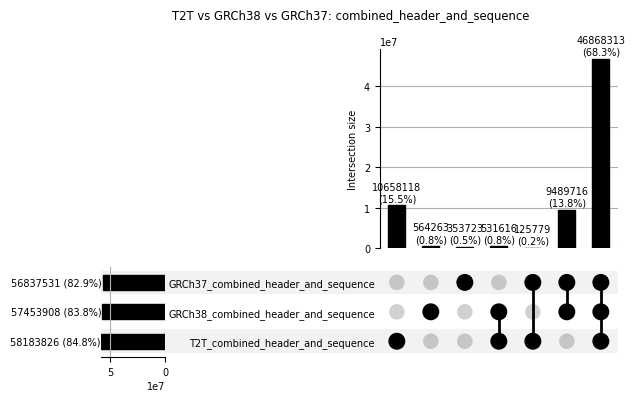

In [17]:
t2t_upset_plot = show_upset_within_references(sequence_names_set_genome_t2t, sequence_names_set_cdna_t2t, title = "T2T genome vs cDNA")
grch38_upset_plot = show_upset_within_references(sequence_names_set_genome_grch38, sequence_names_set_cdna_grch38, title = "GRCh38 genome vs cDNA")
grch37_upset_plot = show_upset_within_references(sequence_names_set_genome_grch37, sequence_names_set_cdna_grch37, title = "GRCh37 genome vs cDNA")

genome_upset_plot = show_upset_between_references(sequence_names_set_genome_t2t, sequence_names_set_genome_grch38, sequence_names_set_genome_grch37, "genome_header")
cdna_upset_plot = show_upset_between_references(sequence_names_set_cdna_t2t, sequence_names_set_cdna_grch38, sequence_names_set_cdna_grch37, "cdna_header")
combined_upset_plot = show_upset_between_references(sequence_names_set_t2t, sequence_names_set_grch38, sequence_names_set_grch37, "combined_header")

header_and_sequence_genome_upset_plot = show_upset_between_references(header_and_sequence_set_genome_t2t, header_and_sequence_set_genome_grch38, header_and_sequence_set_genome_grch37, "genome_header_and_sequence")
header_and_sequence_cdna_upset_plot = show_upset_between_references(header_and_sequence_set_cdna_t2t, header_and_sequence_set_cdna_grch38, header_and_sequence_set_cdna_grch37, "cdna_header_and_sequence")
header_and_sequence_upset_plot = show_upset_between_references(header_and_sequence_set_t2t, header_and_sequence_set_grch38, header_and_sequence_set_grch37, "combined_header_and_sequence")

In [86]:
#*** to recreate headers to remove for synthetic read tests, uncomment the line below and simply run the import/hyperparameter/definition files and then this cell and all below
# sequence_names_set_genome_grch37, sequence_names_set_cdna_grch37, header_and_sequence_set_genome_grch37, header_and_sequence_set_cdna_grch37 = run_full_alignment_workflow(bowtie_reference_folder_parent = bowtie_reference_folder_parent, mutation_reference_file_fasta = mutation_reference_file_fasta, reference_source = "grch37", release = ensembl_version_dlist_grch37, dfk_length = dfk_length, threads = threads, k = k)

mutation_reference_file_fasta_and_bowtie_grch37_cdna = f"/home/jrich/Desktop/gget_mutate_project_clean_k{k}_transcriptome/data/mutant_reference/cancer_mutant_reference_transcriptome_cdna_filtered_bowtie_cdna_grch37.fa"
mutation_reference_file_fastQ_and_bowtie_grch37_cdna = f"/home/jrich/Desktop/gget_mutate_project_clean_k{k}_transcriptome/data/mutant_reference/cancer_mutant_reference_transcriptome_cdna_filtered_bowtie_cdna_grch37.fastq"
mutation_reference_file_fasta_final_grch37 = f"/home/jrich/Desktop/gget_mutate_project_clean_k{k}_transcriptome/data/mutant_reference/cancer_mutant_reference_transcriptome_cdna_filtered_bowtie_cdna_grch37_kbextract.fa"

base_folder_normal_index = f"/home/jrich/Desktop/gget_mutate_project_clean_k{k}_transcriptome/data"
kb_output_path = f"{bowtie_reference_folder_parent}/kb_output"
kb_ref_wt = f"{kb_output_path}/grch37_reference"
os.makedirs(kb_ref_wt, exist_ok=True)
kb_human_reference_index_file = f"{kb_ref_wt}/index.idx"
kb_human_reference_t2g_file = f"{kb_ref_wt}/t2g.txt"
kb_human_reference_f1_file = f"{kb_ref_wt}/f1.fasta"

kb_extract_out_dir_bowtie_filtered = f"{kb_output_path}/kb_extract_out_dir_bowtie_filtered"

kb_human_reference_f2_file = f"{kb_ref_wt}/f2.fasta"
kb_human_reference_c1_file = f"{kb_ref_wt}/c1.fasta"
kb_human_reference_c2_file = f"{kb_ref_wt}/c2.fasta"
kb_ref_workflow_line = f"-f2 {kb_human_reference_f2_file} -c1 {kb_human_reference_c1_file} -c2 {kb_human_reference_c2_file} --workflow=nac --make-unique"
kb_count_workflow_line = f"--workflow=nac -c1 {kb_human_reference_c1_file} -c2 {kb_human_reference_c2_file} --sum=total"

human_reference_for_dlist_folder = f'{bowtie_reference_folder_parent}/reference/GRCh_Ensembl/GRCh37_Ensembl{ensembl_version_dlist_grch37}'
genome_fasta = f"{human_reference_for_dlist_folder}/Homo_sapiens.GRCh37.dna.primary_assembly.fa"
gtf_file = f"{human_reference_for_dlist_folder}/Homo_sapiens.GRCh37.87.gtf"

filter_fasta(mutation_reference_file_fasta, mutation_reference_file_fasta_and_bowtie_grch37_cdna, sequence_names_set_cdna_grch37)  # filter out values in sequence_names_set_cdna_grch37 since this is where 

fasta_to_fastq(mutation_reference_file_fasta_and_bowtie_grch37_cdna, mutation_reference_file_fastQ_and_bowtie_grch37_cdna, k=None)

!kb ref -i {kb_human_reference_index_file} \
    -g {kb_human_reference_t2g_file} \
    -f1 {kb_human_reference_f1_file} \
    {kb_ref_workflow_line} \
    --d-list=None \
    -k {k} \
    -t {threads} \
    {genome_fasta} \
    {gtf_file}

!kb extract \
    --extract_all_fast \
    --mm \
    --verbose \
    -t $threads \
    -k {k} \
    -o $kb_extract_out_dir_bowtie_filtered \
    -i $kb_human_reference_index_file \
    -g $kb_human_reference_t2g_file \
    $mutation_reference_file_fastQ_and_bowtie_grch37_cdna

kb_extract_output_fastq_file = f"{kb_extract_out_dir_bowtie_filtered}/all/1.fastq.gz"

problematic_mutations_total = parse_fastq(kb_extract_output_fastq_file)



filter_fasta(mutation_reference_file_fasta_and_bowtie_grch37_cdna, mutation_reference_file_fasta_final_grch37, problematic_mutations_total)

print(f"number of pseudoaligned reads identified by kb extract: {len(problematic_mutations_total)}")

[2024-08-16 09:54:45,260]    INFO [ref_nac] Preparing /home/jrich/Desktop/gget_mutate_project_clean_k31_transcriptome/data/TEMP_bowtie_tests/reference/GRCh_Ensembl/GRCh37_Ensembl93/Homo_sapiens.GRCh37.dna.primary_assembly.fa, /home/jrich/Desktop/gget_mutate_project_clean_k31_transcriptome/data/TEMP_bowtie_tests/reference/GRCh_Ensembl/GRCh37_Ensembl93/Homo_sapiens.GRCh37.87.gtf
[2024-08-16 09:55:38,994]    INFO [ref_nac] Splitting genome /home/jrich/Desktop/gget_mutate_project_clean_k31_transcriptome/data/TEMP_bowtie_tests/reference/GRCh_Ensembl/GRCh37_Ensembl93/Homo_sapiens.GRCh37.dna.primary_assembly.fa into cDNA at /home/jrich/Desktop/CART_prostate_sc/tmp/tmp6tazbs8c
[2024-08-16 09:56:36,965]    INFO [ref_nac] Creating cDNA transcripts-to-capture at /home/jrich/Desktop/CART_prostate_sc/tmp/tmpm3v2s0ss
[2024-08-16 09:56:37,879]    INFO [ref_nac] Splitting genome into unprocessed transcripts at /home/jrich/Desktop/CART_prostate_sc/tmp/tmpg757pyhf
[2024-08-16 09:58:10,646]    INFO [ref_

In [87]:
mutation_reference_file_index = f"/home/jrich/Desktop/gget_mutate_project_clean_k{k}_transcriptome/data/mutant_reference/mutation_index_for_synthetic_reads.idx"

!kb ref \
    --workflow custom \
    -t $threads \
    -i $mutation_reference_file_index \
    --d-list=None \
    -k {k} \
    $mutation_reference_file_fasta_final_grch37

mutation_reference_file_fasta_final_grch37_t2g = f"/home/jrich/Desktop/gget_mutate_project_clean_k{k}_transcriptome/data/mutant_reference/mutation_t2g_for_synthetic_reads.txt"
create_identity_t2g(mutation_reference_file_fasta_final_grch37, mutation_reference_file_fasta_final_grch37_t2g)

[2024-08-16 11:05:42,820]    INFO [ref_custom] Indexing /home/jrich/Desktop/gget_mutate_project_clean_k31_transcriptome/data/mutant_reference/cancer_mutant_reference_transcriptome_cdna_filtered_bowtie_cdna_grch37_kbextract.fa to /home/jrich/Desktop/gget_mutate_project_clean_k31_transcriptome/data/mutant_reference/mutation_index_for_synthetic_reads.idx
[2024-08-16 11:08:17,259]    INFO [ref_custom] Finished creating custom index


In [88]:
sequence_names_set_cdna_grch37_and_kbextract = sequence_names_set_cdna_grch37 | set(problematic_mutations_total)

# Path to save the set
file_path = f"/home/jrich/Desktop/gget_mutate_project_clean_k{k}_transcriptome/data/mutant_reference/mutation_headers_to_filter_out_for_synthetic_reads.txt"

# Save the set to a text file
with open(file_path, "w") as file:
    for item in sequence_names_set_cdna_grch37_and_kbextract:
        file.write(f"{item}\n")

YAT

In [ ]:
mutation_reference_file_fasta_kb_filtered_only = "/home/jrich/Desktop/CART_prostate_sc/data/mutation_reference_for_synthetic_reads/mutation_reference_file_fasta_kb_filtered_only.fa"
filter_fasta(mutation_reference_file_fasta, mutation_reference_file_fasta_kb_filtered_only, problematic_mutations_total)

dlist_fasta_file_cdna_grch37 = "/home/jrich/Desktop/CART_prostate_sc/data/mutation_reference_for_synthetic_reads/dlist_fasta_file_cdna_grch37.fa"
mutation_reference_file_fasta_kb_and_grch37_perfect_substring_filtered = "/home/jrich/Desktop/CART_prostate_sc/data/mutation_reference_for_synthetic_reads/mutation_reference_file_fasta_kb_and_grch37_perfect_substring_filtered.fa"
dlist_fasta_file_filtered_by_dlist_perfect_substring_cdna_grch37 = "/home/jrich/Desktop/CART_prostate_sc/data/mutation_reference_for_synthetic_reads/dlist_fasta_file_filtered_by_dlist_perfect_substring_cdna_grch37.fa"
remove_mutations_which_are_a_perfect_substring_of_wt_reference_genome(mutation_reference_file_fasta, dlist_fasta_file_cdna_grch37, output_fasta = mutation_reference_file_fasta_kb_and_grch37_perfect_substring_filtered, output_dlist = dlist_fasta_file_filtered_by_dlist_perfect_substring_cdna_grch37)

In [ ]:
#!!! DLIST STUFF

mutation_reference_file_index = "/home/jrich/Desktop/CART_prostate_sc/data/mutation_reference_for_synthetic_reads/mutation_index_with_dlist_for_synthetic_reads.idx"

!kb ref \
    --workflow custom \
    -t $threads \
    -i $mutation_reference_file_index \
    --d-list={dlist_fasta_file_filtered_by_dlist_perfect_substring_cdna_grch37} \
    -k {k} \
    $mutation_reference_file_fasta_kb_and_grch37_perfect_substring_filtered

mutation_reference_file_fasta_final2_grch37_t2g = "/home/jrich/Desktop/CART_prostate_sc/data/mutation_reference_for_synthetic_reads/mutation_t2g_with_dlist_for_synthetic_reads.txt"
create_identity_t2g(mutation_reference_file_fasta_kb_and_grch37_perfect_substring_filtered, mutation_reference_file_fasta_final2_grch37_t2g)